# Surge Index

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from numpy import intersect1d
from datetime import datetime
from pyathena import connect

# add ethereum to python path (only need to do this once)
import sys
sys.path.insert(0, "/home/ec2-user/SageMaker/ethereum")

from ethereum import (
    timestamp_to_datetime,
    EthereumData
)
from utils import (
    latest,
    lead_lag,
    add_latest_avail_block,
    lagged_block_data
)

In [9]:
def select_query(table, db="ethereumetl", cols=None, where=None, limit=10):
    
    if cols:
        cols_str = ', '.join(cols)
    else:
        cols_str = "*"
        
    if where:
        where_str = " WHERE " + " and ".join(where)
    else:
        where_str = ""
    
    if limit:
        limit_str = " LIMIT " + str(limit)
    else:
        limit_str = ""
    
    query = f"SELECT {cols_str} FROM {db}.{table}{where_str}{limit_str}"
    
    return query

def query(sql, s3_staging_dir='s3://sagemaker-w210-eth/raw_data/August/', region_name='us-west-2'):
    
    conn = connect(s3_staging_dir=s3_staging_dir, region_name=region_name)
    res = pd.read_sql(sql, conn)
    conn.close()
    
    return res

In [17]:
blocks = query(select_query("blocks", limit=False)).set_index('number')

blocks['datetime'] = pd.to_datetime(blocks['timestamp'],unit='s')
blocks['date'] = blocks['datetime'].dt.date

#### Empty Blocks

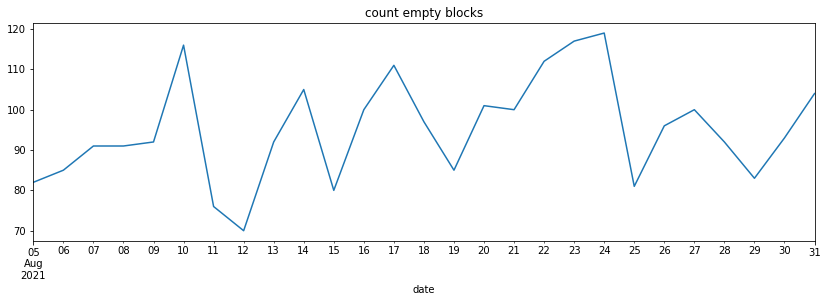

In [167]:
empty_blocks = blocks.query('gas_used == 0')
empty_blocks = empty_blocks.reset_index().groupby('date').count()['number']
empty_blocks.index = pd.to_datetime(empty_blocks.index)
empty_blocks.plot(title='count empty blocks', figsize=(14, 4));
# https://medium.com/@ASvanevik/why-all-these-empty-ethereum-blocks-666acbbf002
# "SPV Mining"

In [253]:
blocks_clean = blocks.query('gas_used != 0')

gas_fee = blocks_clean[[
    'datetime', 'base_fee_per_gas'
]].set_index('datetime').sort_index().dropna()
gas_fee.index = pd.to_datetime(gas_fee.index)

#### Daily Quantiles
- Need to remove the long-term trend in base_fee_per_gas to get a "jump index"
- Anything from 0.1 to 0.5 seemed like a good choice for this
    - This number determines how often the surge index will be 1

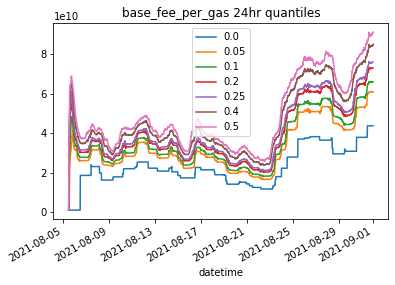

In [255]:
quantiles = [0, 0.05, 0.1, 0.2, 0.25, 0.4, 0.5]

quntile_df = pd.DataFrame({
    k : gas_fee['base_fee_per_gas'].rolling('24h').quantile(k) for k in quantiles
})
quntile_df.plot(title='base_fee_per_gas 24hr quantiles');

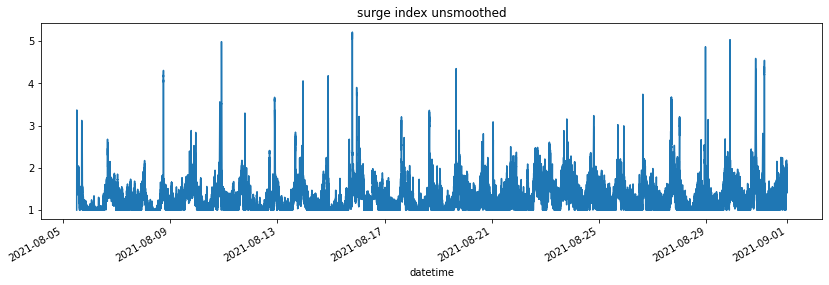

In [288]:
quantile_threshold = 0.25
surge_index_unsmooth = (np.log(
    gas_fee / gas_fee.rolling('24h').quantile(quantile_threshold)
).clip(lower=0) + 1)['base_fee_per_gas']
surge_index_unsmooth.plot(title='surge index unsmoothed', figsize=(14, 4));

#### Smoothing
* Opting for 15 blocks smoothing
    - 15 blocks smoothing gives you more realistic jumps
    - 50 blocks smoothing is less scary

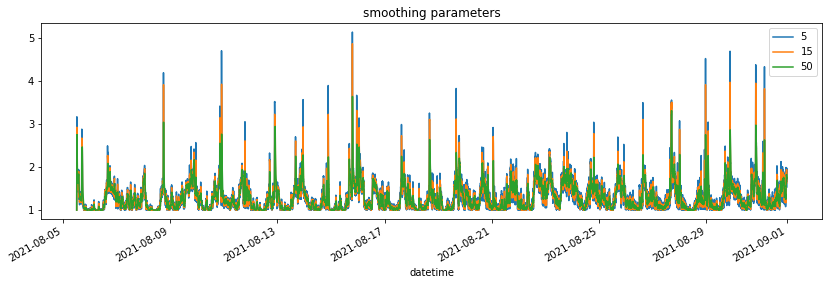

In [307]:
ewm_lookbacks = [5, 15, 50]

surge_index_smooth = pd.DataFrame({
    k : surge_index_unsmooth.ewm(halflife=k).mean() for k in ewm_lookbacks
})
surge_index_smooth.plot(title='smoothing parameters', figsize=(14, 4));

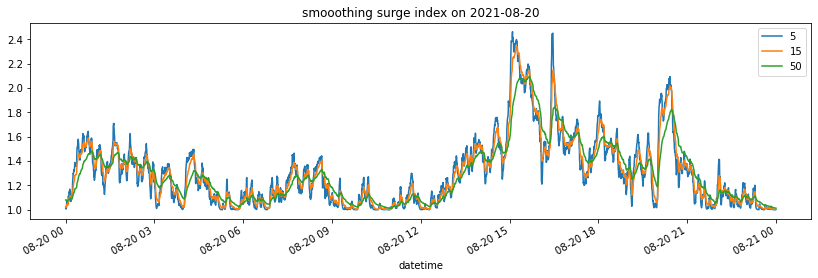

In [309]:
dt = "2021-08-20"

surge_index_smooth_dt = surge_index_smooth[gas_fee.index.date == pd.to_datetime(dt)]
surge_index_smooth_dt.plot(title=f"smooothing surge index on {dt}", figsize=(14, 4));

In [310]:
def surge_index(data, rolling_lookback='24h', quantile=0.25, halflife=15):
    
    normalized_data = data / data.rolling(rolling_lookback).quantile(quantile_threshold)
    idx = (np.log(normalized_data).clip(lower=0) + 1)
    smoothed_index = idx.ewm(halflife=halflife).mean()
    
    return smoothed_index

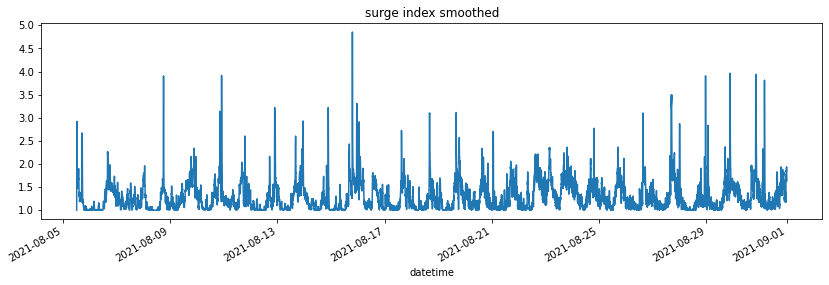

In [311]:
surge_index_calc = surge_index(gas_fee['base_fee_per_gas'])
surge_index_calc.plot(title = 'surge index smoothed', figsize=(14, 4));

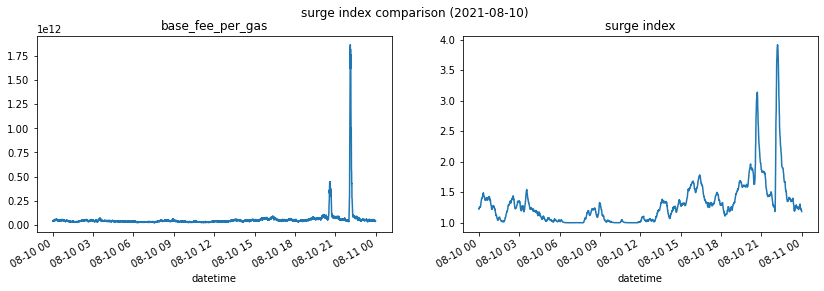

In [317]:
dt = "2021-08-10"

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
gas_fee_dt = gas_fee[gas_fee.index.date == pd.to_datetime(dt)]
surge_index_dt = surge_index_calc[gas_fee.index.date == pd.to_datetime(dt)]

gas_fee_dt['base_fee_per_gas'].plot(title=f"base_fee_per_gas", ax=axes[0])
surge_index_dt.plot(title=f"surge index", ax=axes[1])
fig.suptitle(f"surge index comparison ({dt})");